<a href="https://colab.research.google.com/github/Dopamine-Max/CNN-Milestone-projects/blob/main/Cifar10_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# #2 CNN MILESTONE PROJECT
##Pushing the Cifar10 Dataset through an Autoencoder
####Builiding a CNN as an autoencoder that encodes the images from Cifar10 and displays the result comparing it to the original

In [ ]:
# import libraries

import numpy as np
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary

import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-158-a561a675aacf>:19: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# transformations and importing the data

cdata = torchvision.datasets.CIFAR10(root='./data', download=True)

#extract data and labels
data = cdata.data
labels = cdata.targets

#normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

#convert to torch tensor format
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

#reshape the data
dataT = dataT.reshape([50000,3,32,32]).float()

#Step 1: split the data twice
train_data,test_data,train_labels,test_labels = train_test_split(dataT, labelsT, train_size=0.9)

#Step 2: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

#Step 3: translate into dataloader objects
train_loader = DataLoader(train_data,batch_size=32,shuffle=True,drop_last=True)
#200 batch_size works better in case batch norm is enabled but worse without
test_loader  = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

Files already downloaded and verified


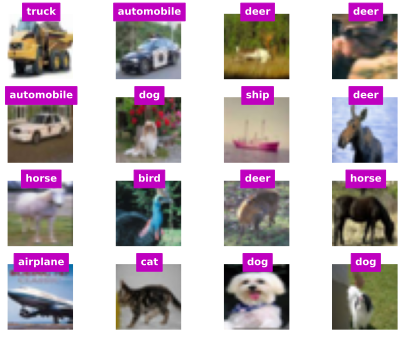

In [ ]:
# inspect a few images
X,y = next(iter(train_loader))

fig,axs = plt.subplots(4,4)

for (i,ax) in enumerate(axs.flatten()):

  #extract that image (need to transpose it back to 32x32x3)
  pic = X[i,:,:,:].reshape([32,32,3])

  #and its label
  label = cdata.classes[y[i]]

  #and
  ax.imshow(pic)
  ax.text(16,0,label,ha='center',fontweight='bold',color='w',backgroundcolor='m')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# create a class for the model
def maketheNet():

  class cifar10AE(nn.Module):
    def __init__(self):
      super().__init__()

      #encoding layer
      self.enc = nn.Sequential(

          #first convolution encoding layer
          nn.Conv2d(3,16,4,2,padding=1),
          # nn.BatchNorm2d(16), #BatchNorm adds random undesired rgb pixels to the output
          nn.LeakyReLU(),

          #second convolution encoding layer
          nn.Conv2d(16,32,4,2,padding=1),
          # nn.BatchNorm2d(32),
          nn.LeakyReLU(),

          # latent encoding layer
          nn.Conv2d(32,64,4,2,padding=1),
          # nn.BatchNorm2d(64),
          nn.LeakyReLU()
      )

      #decoding layer
      self.dec = nn.Sequential(

          #latent decoding layer
          nn.ConvTranspose2d(64,32,4,2,padding=1),
          # nn.BatchNorm2d(32),
          nn.LeakyReLU(),

          #first convolution decoding layer
          nn.ConvTranspose2d(32,16,4,2,padding=1),
          # nn.BatchNorm2d(16),
          nn.LeakyReLU(),

          #second convolution decoding layer
          nn.ConvTranspose2d(16,3,4,2,padding=1),
          )

    def forward(self,x):
      return self.dec(self.enc(x))

  #create the model instance
  net = cifar10AE()

  #loss function
  lossfun = nn.MSELoss()

  #optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001) #.01 is too quick for 32 batch size

  return net,lossfun,optimizer

 
torch.Size([10, 3, 32, 32])


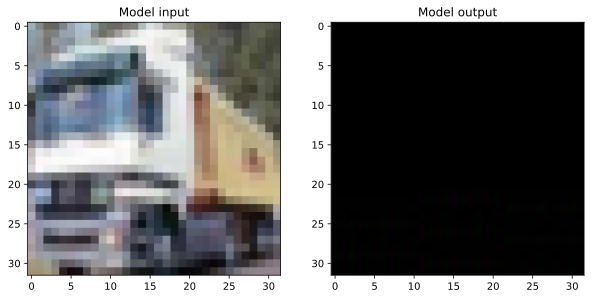

In [ ]:
# test the model with one batch
net,lossfun,optimizer = maketheNet()

yHat = net(dataT[:10,:,:,:])

# check size of output
print(' ')
print(yHat.shape)

pic = dataT[1,:,:,:]
pic = pic.reshape([32,32,3])
pic1 = yHat[1,:,:,:]
pic1 = pic1.reshape([32,32,3])

# let's see how they look
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(torch.squeeze(pic).detach())
ax[0].set_title('Model input')
ax[1].imshow(torch.squeeze(pic1).detach())
ax[1].set_title('Model output')

plt.show()

In [ ]:
# count the total number of parameters in the model
net.to(device)
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             784
         LeakyReLU-2           [-1, 16, 16, 16]               0
            Conv2d-3             [-1, 32, 8, 8]           8,224
         LeakyReLU-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 4, 4]          32,832
         LeakyReLU-6             [-1, 64, 4, 4]               0
   ConvTranspose2d-7             [-1, 32, 8, 8]          32,800
         LeakyReLU-8             [-1, 32, 8, 8]               0
   ConvTranspose2d-9           [-1, 16, 16, 16]           8,208
        LeakyReLU-10           [-1, 16, 16, 16]               0
  ConvTranspose2d-11            [-1, 3, 32, 32]             771
Total params: 83,619
Trainable params: 83,619
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

In [ ]:
# function that trains the model

def traincifar10AE():

  #number of epochs
  numepochs = 10

  #create a new model
  net,lossfun,optimizer = maketheNet()

  #send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)


  #loop over epochs
  for epochi in range(numepochs):

    #loop over training data batches
    batchLoss = []
    for X,y in train_loader:

      #push data to GPU
      X = X.to(device)
      y = y.to(device)

      #forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,X)

      #backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      #loss from this batch
      batchLoss.append(loss.item())

    #end of batch loop...

    #average loss across batches
    trainLoss[epochi] = np.mean(batchLoss)


    #test computation
    X,y = next(iter(test_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    #forward pass and loss
    with torch.no_grad():
      yHat = net(X)
      loss = lossfun(yHat,X)

    # get average losses across the batches
    testLoss[epochi] = loss.item()

  # end epochs

  # function output
  return trainLoss,testLoss,net

In [ ]:
# train the model
trainLoss,testLoss,net = traincifar10AE()

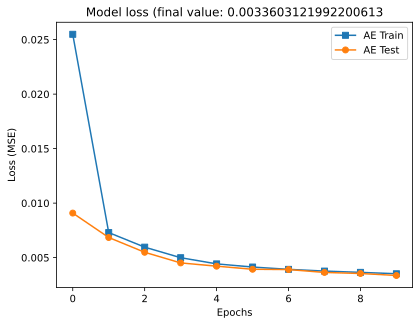

In [ ]:
plt.plot(trainLoss,'s-',label='AE Train')
plt.plot(testLoss,'o-',label='AE Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title(f'Model loss (final value: {testLoss[-1]}')
plt.legend()

plt.show()

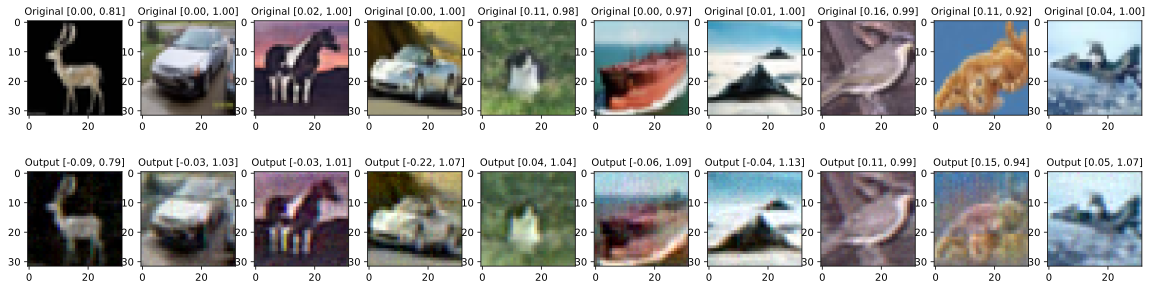

In [ ]:
## show some random examples

# get some data
X,y = next(iter(test_loader))
net.cpu()
yHat = net(X)


fig,axs = plt.subplots(2,10,figsize=(20,5))

for i in range(10):
  # pic = X[i,:,:,:].detach().numpy().transpose((1,2,0)) #another way to get the picture
  pic = X[i,:,:,:].reshape([32,32,3])
  axs[0,i].imshow(torch.squeeze(pic).detach())
  axs[0,i].set_title(f'Original [{torch.min(pic):.2f}, {torch.max(pic):.2f}]',fontsize=10)

  # pic = yHat[i,:,:,:].detach().numpy().transpose((1,2,0))
  pic = yHat[i,:,:,:].reshape([32,32,3])
  axs[1,i].imshow(torch.squeeze(pic).detach())
  axs[1,i].set_title(f'Output [{torch.min(pic):.2f}, {torch.max(pic):.2f}]',fontsize=10)


plt.show()